In [25]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
import os

cwd = os.getcwd()
cwd
benchmark_result_path = os.path.realpath(
    os.path.join(cwd, "../data/benchmark-results.csv")
)
benchmark_result_path

'/Users/csalih/Developer/bsc-web-benchmark/benchmark/benchmark-analyze/data/benchmark-results.csv'

In [40]:
# Load the dataset
df = pd.read_csv(benchmark_result_path, header=None)
df.columns = ["Framework", "Metric", "OS", "Browser", "Value"]

# Drop operating system as it is const for know
df = df.drop(columns=['OS'])

# Groups
df_metric = df.groupby('Metric')

# Display basic info
print(df.head())

     Framework                          Metric   Browser  Value
0  app-angular            create_1000_duration  chromium   61.2
1  app-angular           create_10000_duration  chromium  578.6
2  app-angular       append_1000_rows_duration  chromium   58.7
3  app-angular  update_every_10th_row_duration  chromium    6.5
4  app-angular              swap_rows_duration  chromium    6.4


In [43]:
# Check if there is sufficient data for ANOVA
if df["Framework"].nunique() < 0 or df["Browser"].nunique() < 0:
    print(f"WARNING: Metric {metric} has insufficient data.")


# Group by all factors and count the number of observations
counts = df.groupby(['Framework', 'Metric', 'Browser']).size().reset_index(name='count')
single_observations = counts[counts['count'] == 1]

if not single_observations.empty:
    print("WARNING: The following groups have only one observation. ANOVA may fail:")
    print(single_observations)
    print("Consider combining levels or simplifying your model.")

In [45]:
model = ols('Value ~ C(Framework) * C(Browser)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("Three-Way ANOVA (Framework, Metric, Browser):")
print(anova_table)

Three-Way ANOVA (Framework, Metric, Browser):
                               sum_sq     df         F    PR(>F)
C(Framework)             1.385264e+05    3.0  0.782424  0.504033
C(Browser)               7.562290e+05    2.0  6.406995  0.001768
C(Framework):C(Browser)  2.123600e+04    6.0  0.059973  0.999144
Residual                 3.470134e+07  588.0       NaN       NaN


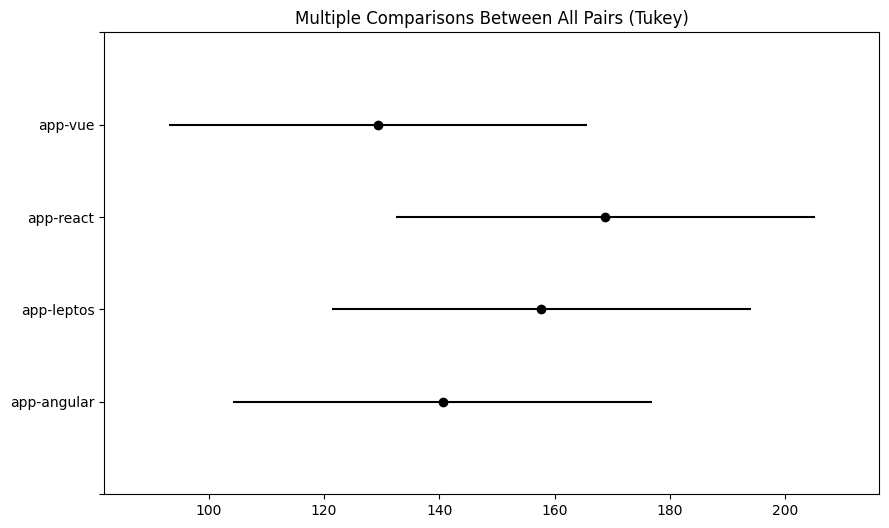

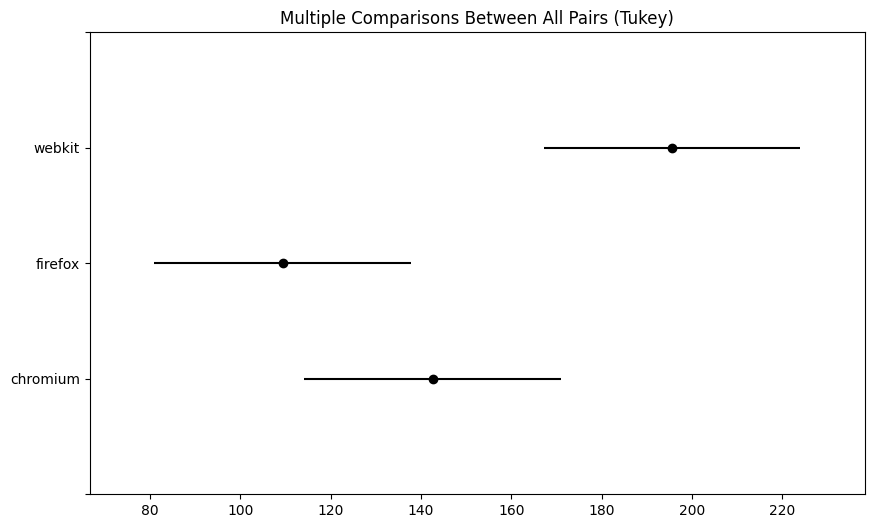

In [34]:
alpha = 0.05
factors = ['Framework', 'Browser']
for factor in factors:
    if anova_table['PR(>F)'][f'C({factor})'] < alpha:
        tukey = pairwise_tukeyhsd(endog=df['Value'],     # Data
                                  groups=df[factor],     # Groups
                                  alpha=alpha)           # Significance level
        
        # Plot group confidence intervals
        tukey.plot_simultaneous()
        plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")
        tukey.summary()

        #print(f"Tukey's HSD Post Hoc Test for {factor}:")
        #print(tukey)
        #print("")